In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/FakeNewsDetector"
!ls

/content/drive/MyDrive/Colab Notebooks/FakeNewsDetector
 all_data.xls		        LSTM.ipynb
 BERT.ipynb		        MultiNB_lime.html
 Bi-LSTM.ipynb		       'Naive Bayes.ipynb'
 FakeNewsNet		        NN.ipynb
 FakeNewsNet.zip	        NNlime_example.html
 lime_bilstm_explanation.html   Preprocess_data.ipynb
 lime_lstm_explanation.html     unzip_data.ipynb
'Logistic Regression.ipynb'     WELFake_data
 LogReglime_example.html        WELFake_data.zip


In [3]:
# importing required libraries
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
import numpy as np

In [4]:
df = pd.read_csv("WELFake_data/WELFake_data.csv")

In [6]:
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [7]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [8]:
#Total num, and investigating NaN
print(len(df))
print(df['label'].isnull().sum())
print(df['title'].isnull().sum())
print(df['text'].isnull().sum())

72134
0
558
39


In [9]:
# Combining the title and text to model
df['title_text'] = df['title'] + ' ' + df['text']
print(df.isnull().sum())
df.head()

title         558
text           39
label           0
title_text    597
dtype: int64


,title,text,label,title_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...
1,NaN,Did they post their votes for Hillary already?,1,NaN
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri..."
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...


In [10]:
#Investigating Fake News Vs Real News Distribution
fake_count = (df["label"] == 0).sum()
real_count = (df["label"] == 1).sum()

print("Fake:", fake_count)
print("Real:", real_count)

Fake: 35028
Real: 37106


EDA

In [12]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

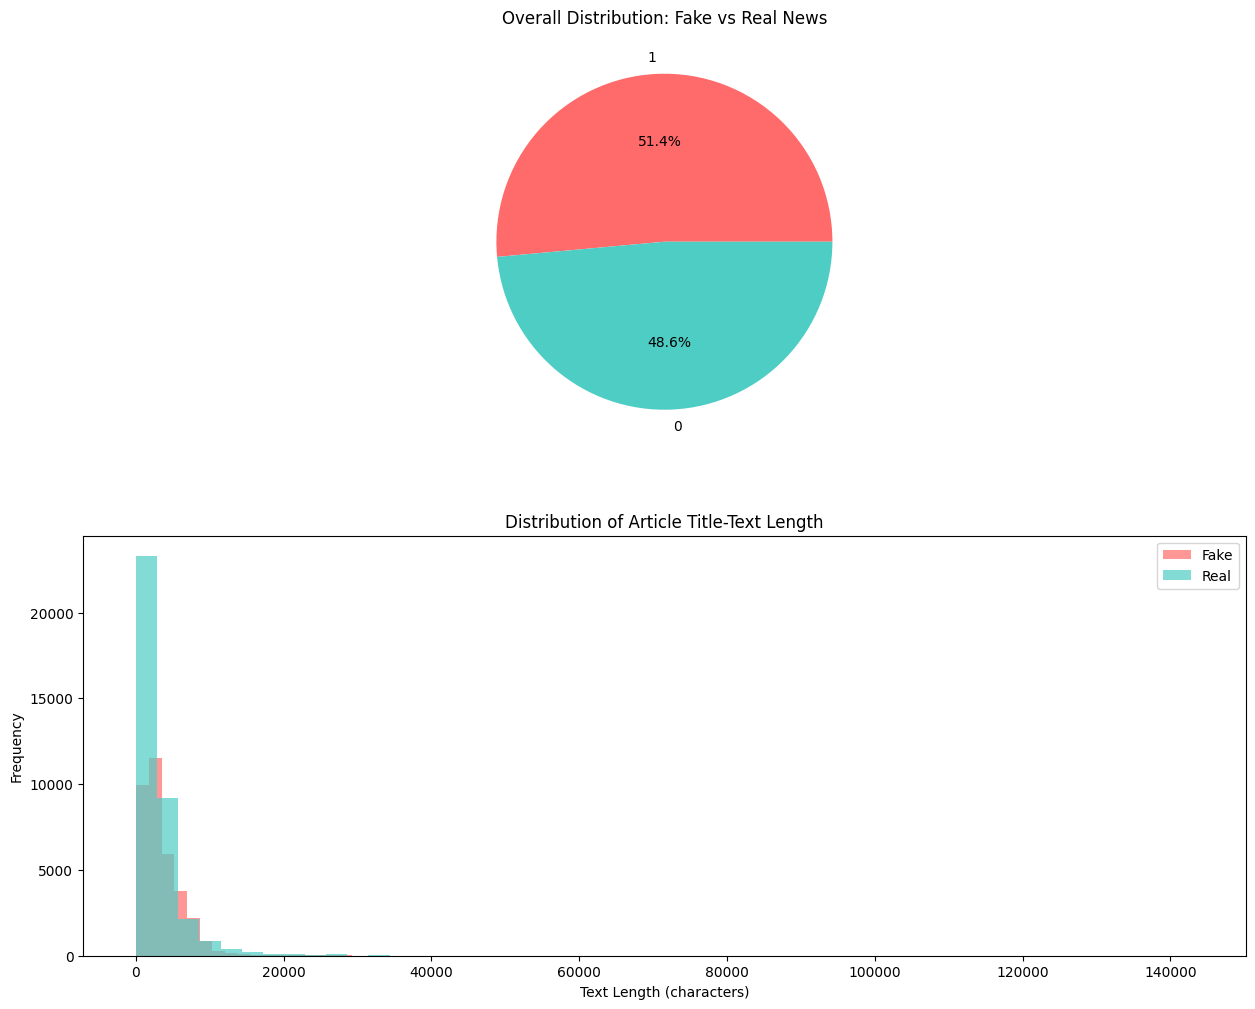

In [19]:
# Create visualizations
def create_visualizations(dataframe):
    """Create comprehensive visualizations"""
    fig, axes = plt.subplots(2, figsize=(15, 12))

    # 1. Overall distribution
    dataframe['label'].value_counts().plot(kind='pie', ax=axes[0], autopct='%1.1f%%',
                                         colors=['#FF6B6B', '#4ECDC4'])
    axes[0].set_title('Overall Distribution: Fake vs Real News')
    axes[0].set_ylabel('')

    # 2. Text length analysis (if text column exists)
    if 'title_text' in dataframe.columns:
        dataframe['text_length'] = dataframe['title_text'].str.len()
        fake_lengths = dataframe[dataframe['label'] == 0]['text_length']
        real_lengths = dataframe[dataframe['label'] == 1]['text_length']

        axes[1].hist(fake_lengths.dropna(), alpha=0.7, label='Fake', bins=50, color='#FF6B6B')
        axes[1].hist(real_lengths.dropna(), alpha=0.7, label='Real', bins=50, color='#4ECDC4')
        axes[1].set_title('Distribution of Article Title-Text Length')
        axes[1].set_xlabel('Text Length (characters)')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()


    plt.show()


create_visualizations(df)

1. Real data is sightly more than the Fake News but not by much.
2. Real News has more frequency of short length text compared to Fake News. Perhaps its because Real News might just focus on facts rather than opinion.

Futher Investigating

In [14]:
# For text column
text_nan_dist = df.groupby("label")["text"].apply(lambda x: x.isna().sum())

# For title column
title_nan_dist = df.groupby("label")["title"].apply(lambda x: x.isna().sum())

print("NaN distribution in TEXT by label:")
print(text_nan_dist.rename(index={0:"Fake", 1:"Real"}))

print("\nNaN distribution in TITLE by label:")
print(title_nan_dist.rename(index={0:"Fake", 1:"Real"}))


NaN distribution in TEXT by label:
label
Fake     0
Real    39
Name: text, dtype: int64

NaN distribution in TITLE by label:
label
Fake      0
Real    558
Name: title, dtype: int64


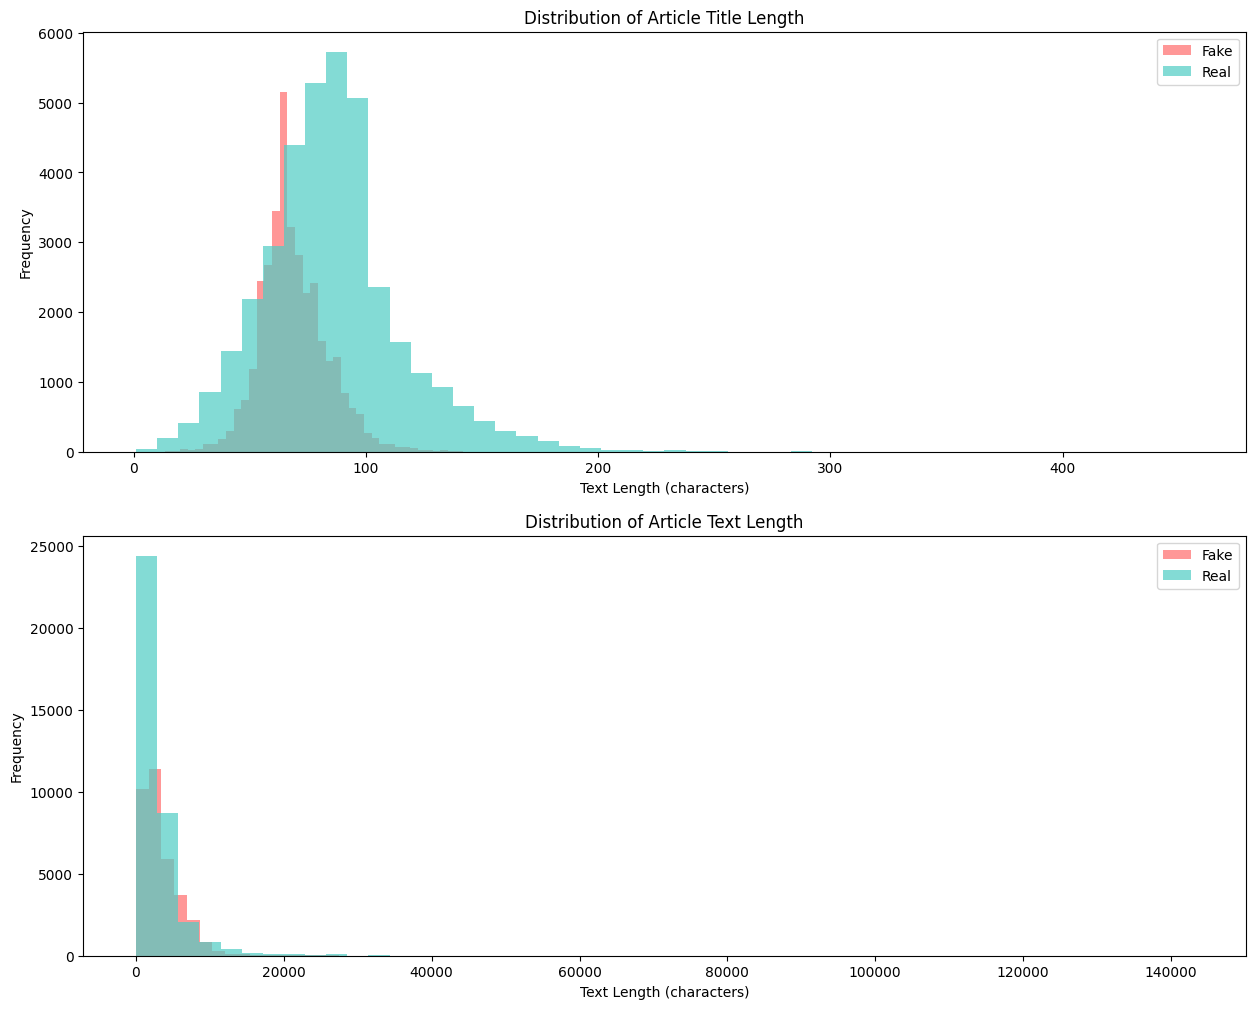

In [20]:
#Text length Individually for Title and Text
# Create visualizations
def Title_Text_visualizations(dataframe):
    """Create comprehensive visualizations"""
    fig, axes = plt.subplots(2, figsize=(15, 12))

    # 1. Text length analysis (if text column exists)
    if 'title' in dataframe.columns:
        dataframe['text_length'] = dataframe['title'].str.len()
        fake_lengths = dataframe[dataframe['label'] == 0]['text_length']
        real_lengths = dataframe[dataframe['label'] == 1]['text_length']

        axes[0].hist(fake_lengths.dropna(), alpha=0.7, label='Fake', bins=50, color='#FF6B6B')
        axes[0].hist(real_lengths.dropna(), alpha=0.7, label='Real', bins=50, color='#4ECDC4')
        axes[0].set_title('Distribution of Article Title Length')
        axes[0].set_xlabel('Text Length (characters)')
        axes[0].set_ylabel('Frequency')
        axes[0].legend()

    # 2. Text length analysis (if text column exists)
    if 'text' in dataframe.columns:
        dataframe['text_length'] = dataframe['text'].str.len()
        fake_lengths = dataframe[dataframe['label'] == 0]['text_length']
        real_lengths = dataframe[dataframe['label'] == 1]['text_length']

        axes[1].hist(fake_lengths.dropna(), alpha=0.7, label='Fake', bins=50, color='#FF6B6B')
        axes[1].hist(real_lengths.dropna(), alpha=0.7, label='Real', bins=50, color='#4ECDC4')
        axes[1].set_title('Distribution of Article Text Length')
        axes[1].set_xlabel('Text Length (characters)')
        axes[1].set_ylabel('Frequency')
        axes[1].legend()


    plt.show()


Title_Text_visualizations(df)

In [18]:
#Removing the NaN rows as they are negligible and doing the Investigating the same
df_clean = df.dropna(subset=["title", "text"])
print("Before:", df.shape)
print("After:", df_clean.shape)

Before: (72134, 5)
After: (71537, 5)


In [22]:
#Investigating Fake News Vs Real News Distribution
fake_count = (df_clean["label"] == 0).sum()
real_count = (df_clean["label"] == 1).sum()

print("Fake:", fake_count)
print("Real:", real_count)

Fake: 35028
Real: 36509


Visualisations

/tmp/ipython-input-1100272896.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['text_length'] = dataframe['title_text'].str.len()


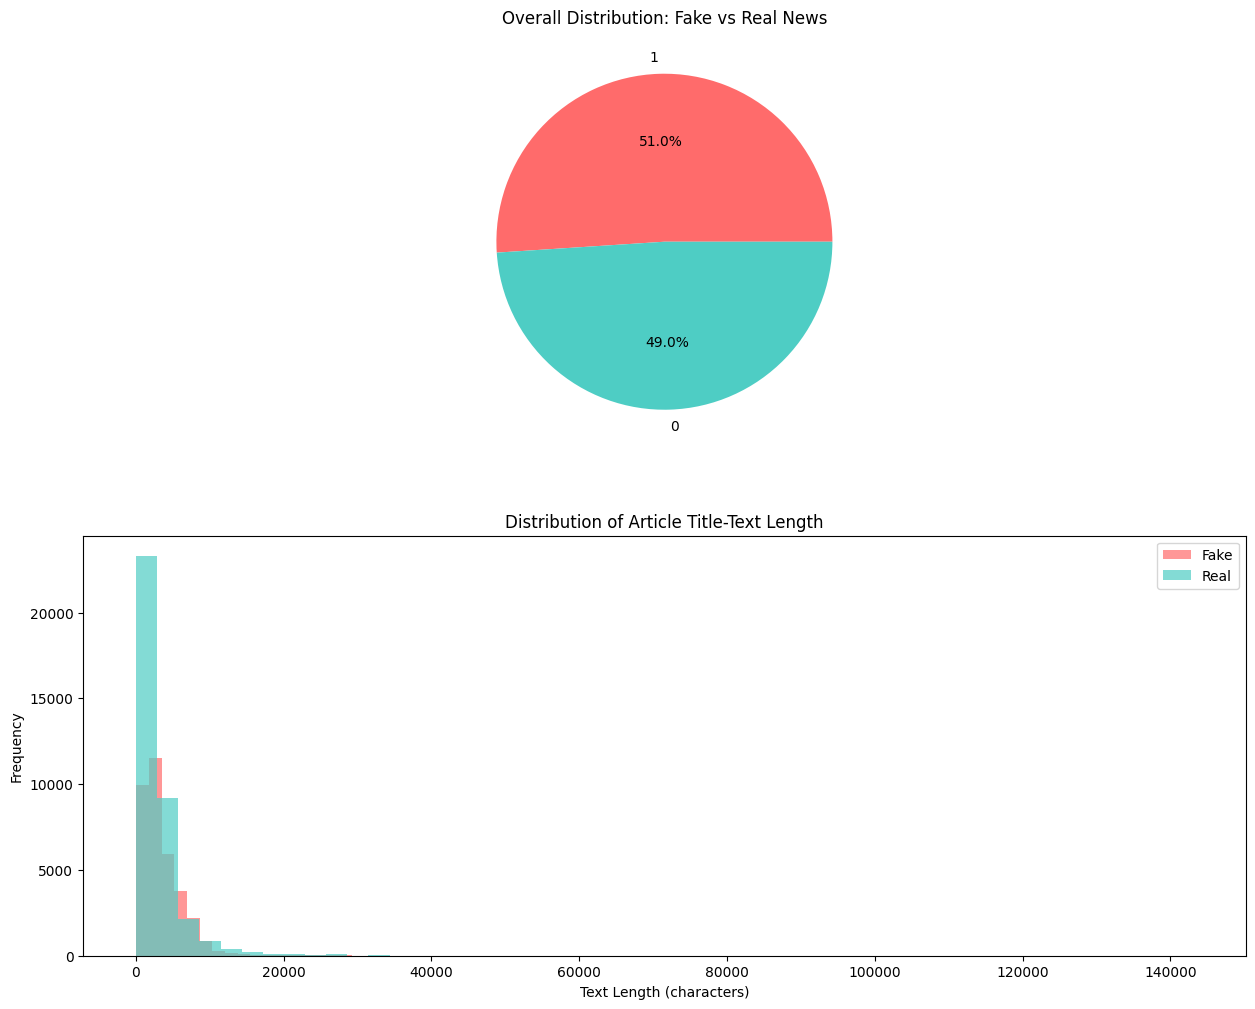

In [21]:
create_visualizations(df_clean)

1. Distibution of Fake News vs Real News has become closer to 50 each. But still a little unbalanced.
2. Text length distribution seems same as before

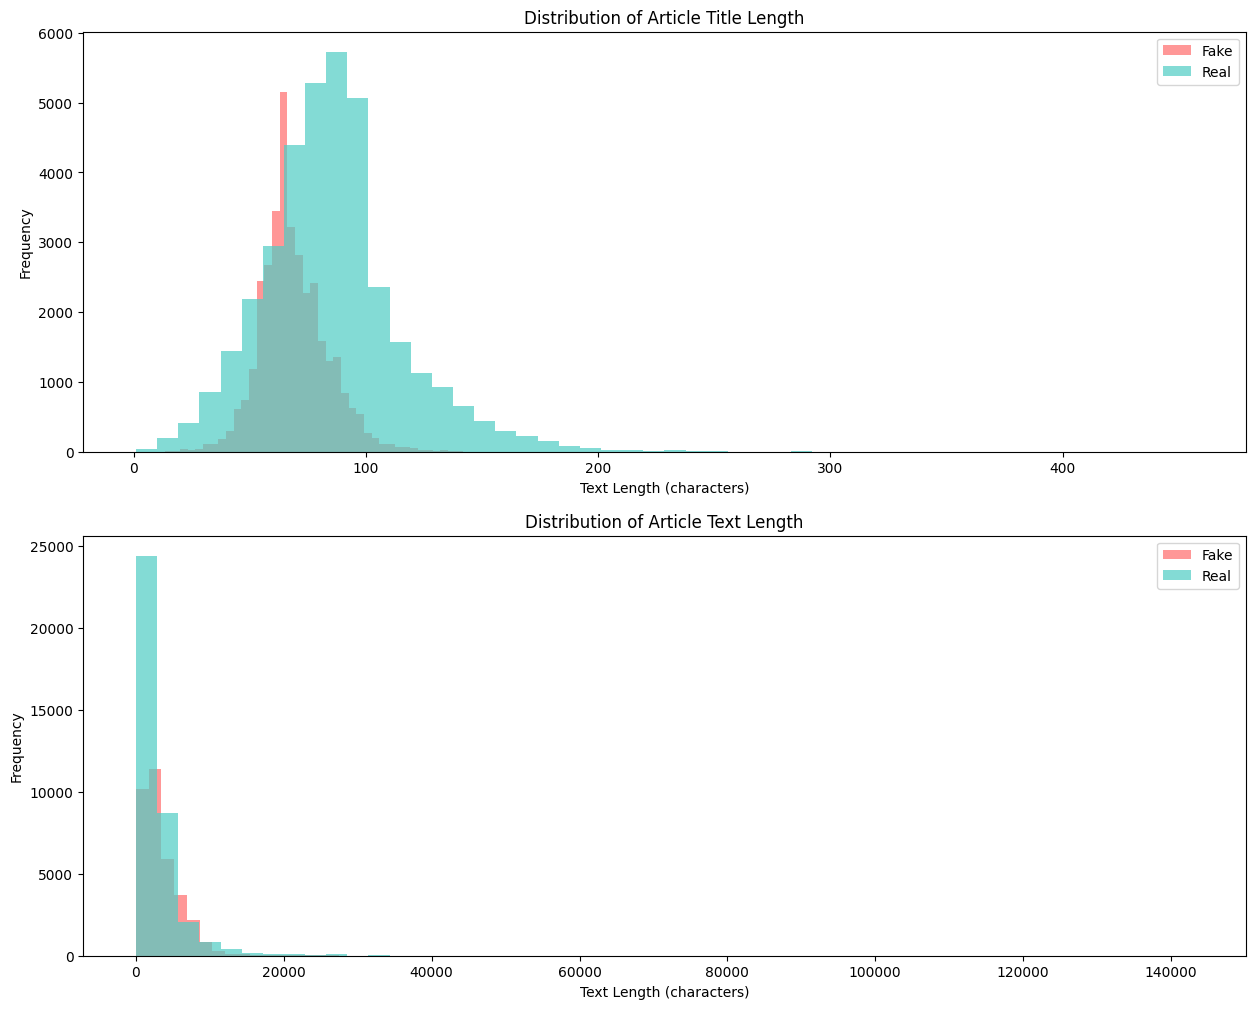

In [23]:
Title_Text_visualizations(df)

In [27]:
#Removing Stopwords and Investigating further
#Importing libraries
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [28]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words("english"))

def remove_stopwords(text):
    if pd.isna(text):
        return text

    text = text.lower()
    text = re.sub(r"http\S+", "", text)     # remove URLs
    text = re.sub(r"[^a-z\s]", "", text)    # remove punctuation & numbers

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]

    return " ".join(tokens)


In [29]:
new_df = df_clean.copy()

new_df["text"] = df_clean["text"].apply(remove_stopwords)
new_df["title"] = df_clean["title"].apply(remove_stopwords)
new_df["title_text"] = df_clean["title_text"].apply(remove_stopwords)

In [37]:
#Any New Empty Rows
print("Before:", df_clean.shape)
print("After:", new_df.shape)
print('\nNaN Distribution')
print(new_df.isnull().sum())

Before: (71537, 5)
After: (71537, 5)

NaN Distribution
title          0
text           0
label          0
title_text     0
text_length    0
dtype: int64


Visualisation

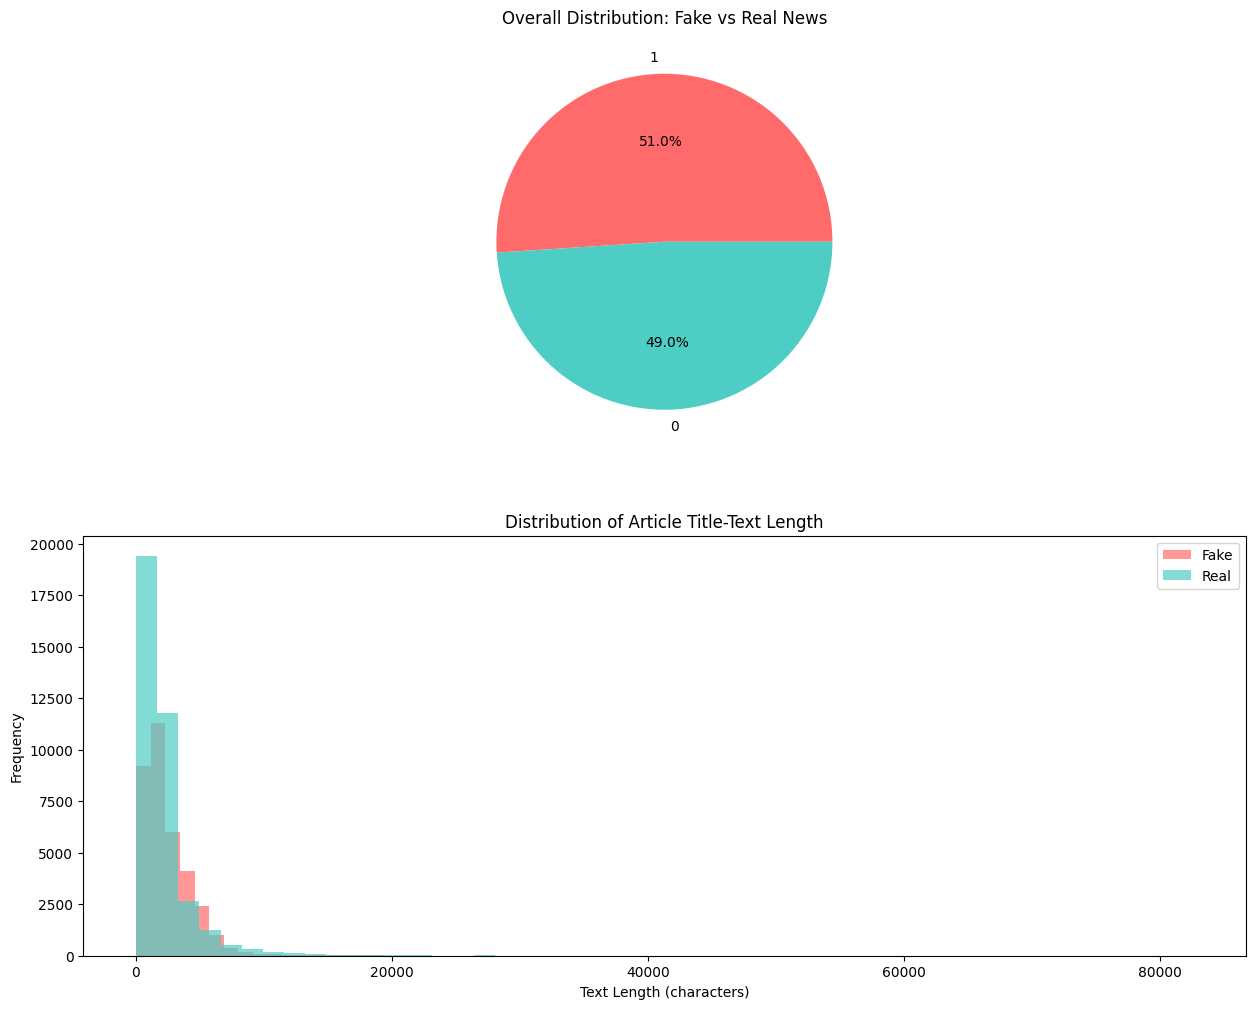

In [38]:
create_visualizations(new_df)

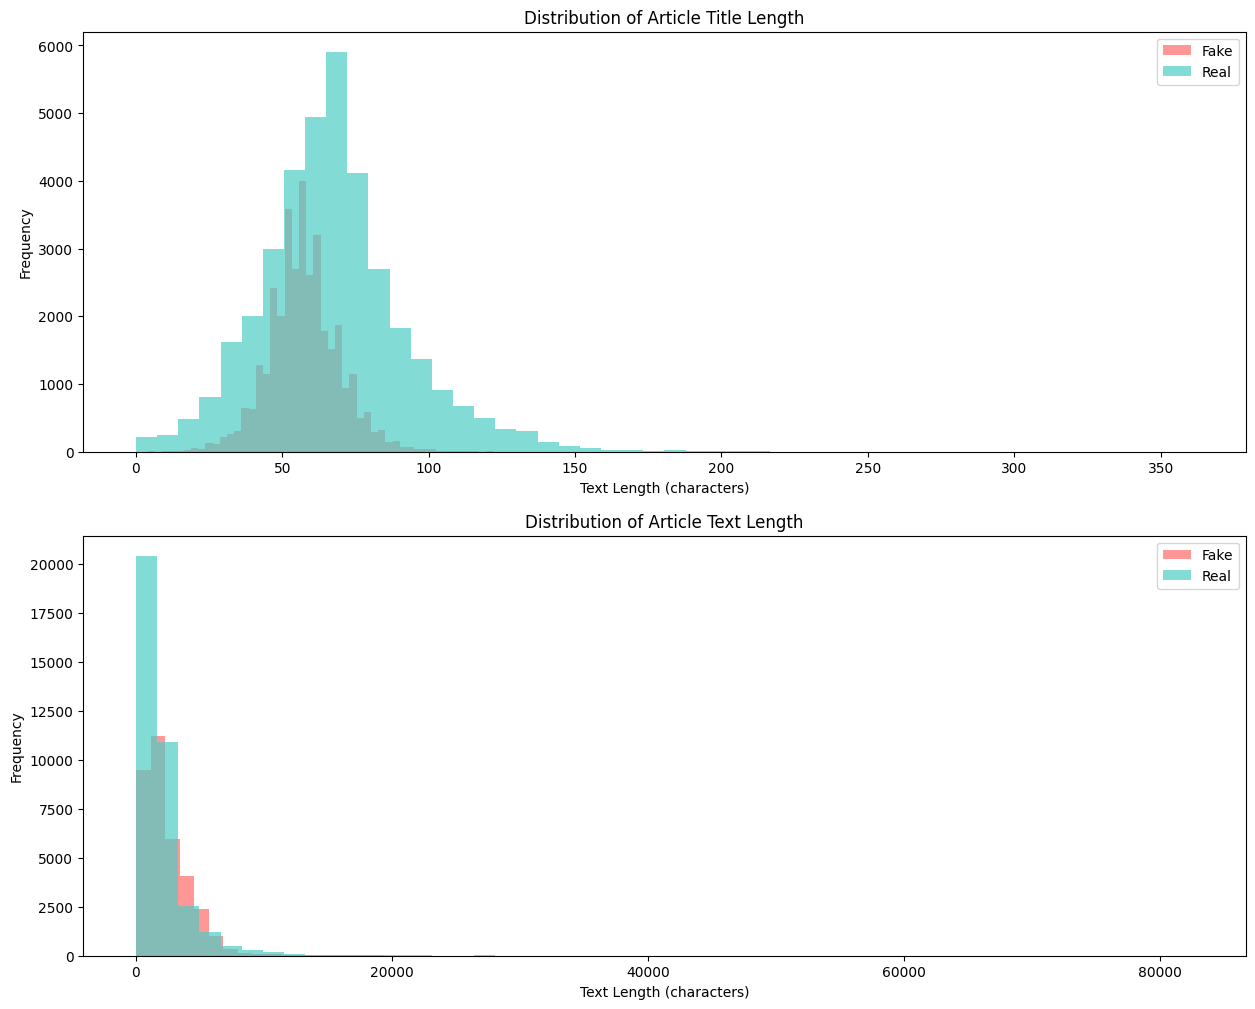

In [39]:
Title_Text_visualizations(new_df)

1. Title Distribution has become more normal.
2. Distribution of short text length has reduced significantly.

WordCloud

In [40]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def plot_fake_real_wordcloud(df, text_column):
    fake_text = " ".join(df[df["label"] == 0][text_column].dropna().astype(str))
    real_text = " ".join(df[df["label"] == 1][text_column].dropna().astype(str))

    wc_fake = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=ENGLISH_STOP_WORDS,
        colormap="Reds"
    ).generate(fake_text)

    wc_real = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=ENGLISH_STOP_WORDS,
        colormap="Blues"
    ).generate(real_text)

    fig, axes = plt.subplots(1, 2, figsize=(14,6))

    axes[0].imshow(wc_fake, interpolation="bilinear")
    axes[0].axis("off")
    axes[0].set_title(f"Most Common Words in Fake News ({text_column})", fontsize=16)

    axes[1].imshow(wc_real, interpolation="bilinear")
    axes[1].axis("off")
    axes[1].set_title(f"Most Common Words in Real News ({text_column})", fontsize=16)

    plt.tight_layout()
    plt.show()

Most Common Words in Combined Title and text


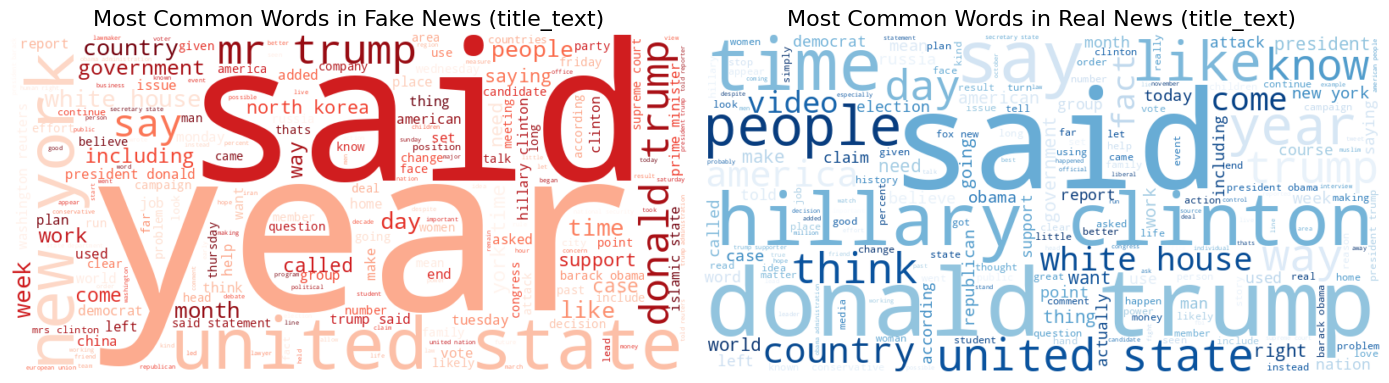

In [44]:
print("Most Common Words in Combined Title and text")
plot_fake_real_wordcloud(new_df, "title_text")

Most Common Words in Title


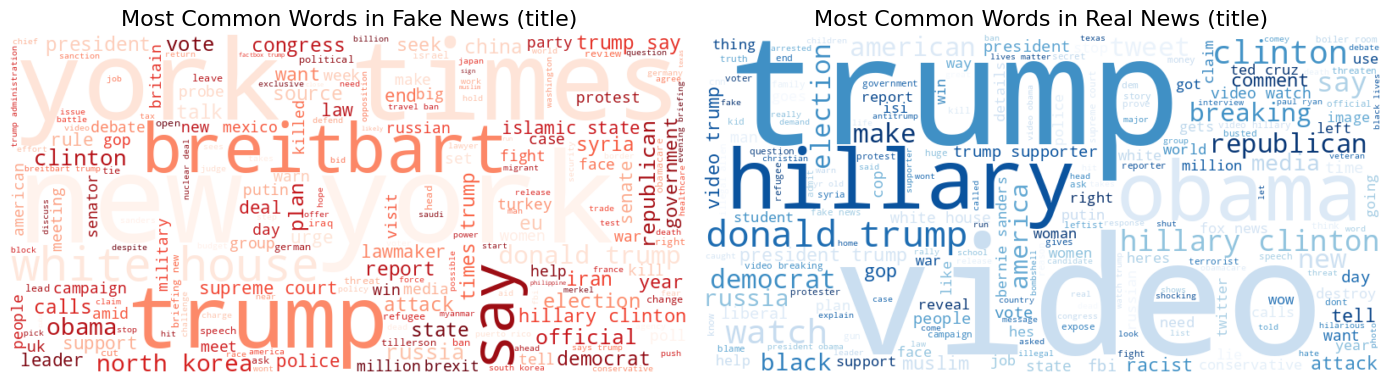

In [45]:
print("Most Common Words in Title")
plot_fake_real_wordcloud(new_df, "title")

Most Common Words in Text


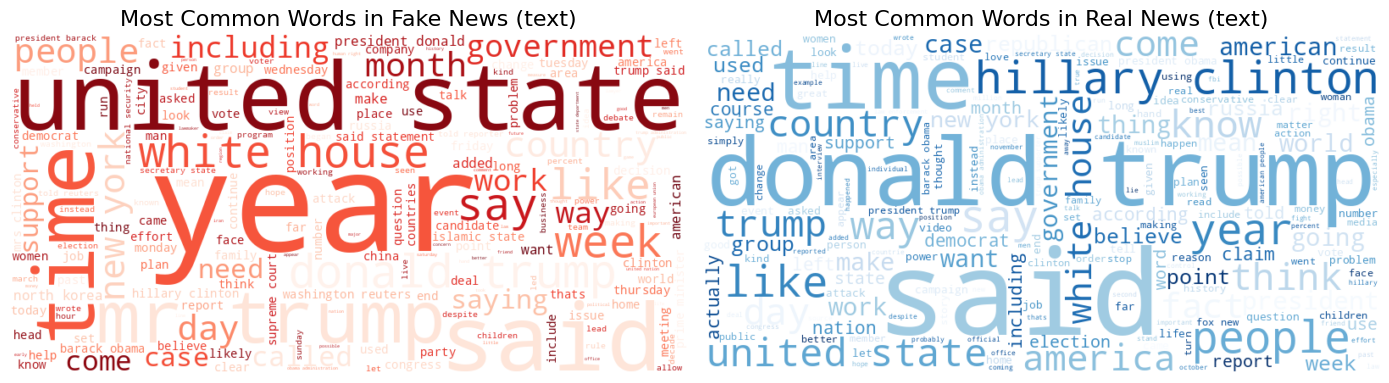

In [46]:
print("Most Common Words in Text")
plot_fake_real_wordcloud(new_df, "text")

In [47]:
new_df.to_csv('WELFake_data/WELFake_data_clean.csv') #saving a new dataset for modeling